# Creating segmented geojson

In this Notebook, I demonstrate how I create geojson for my wildfire of interest. As there are many wildfires with good use cases such as burnt vegetation and trees, destroyed buildings, and areas near the fire that are unharmed or barely harmed -- I created a method that will allow you to segment as much of the CatalogImage you think you require. I suggest editing to the resulting geojson to your desire in QGIS or other GIS software. 


## Spring Creek Fire - Colorado
* 6/27/18
* 108,045 acres

First step will be to load in the image given the bbox. When you look for your wildfire, try to do some research and find the boundaries the fire extends to. 

In [1]:
# 7/3/18
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '104001003FB24500')
bbox = env.inputs.get('bbox', '-105.235, 37.585, -105.148, 37.638')

image = CatalogImage(catalog_id, band_type="MS", pansharpen=True, bbox=map(float, bbox.split(",")))
#image.plot(w=10, h=10)

In this next step, we will divide up the image by 256x256 tiles. You can also change the range to 512x512 or whatever number you desire. 

In [23]:
dim = 256

In [24]:
tiles = []
for x in range(0, image.shape[1], dim):
    for y in range(0,image.shape[2], dim):
        tiles.append(image[:,x:x+dim,y:y+dim])

Below is the result of one of the tiles. Change the index to view other tiles and see if this looks good to you. 

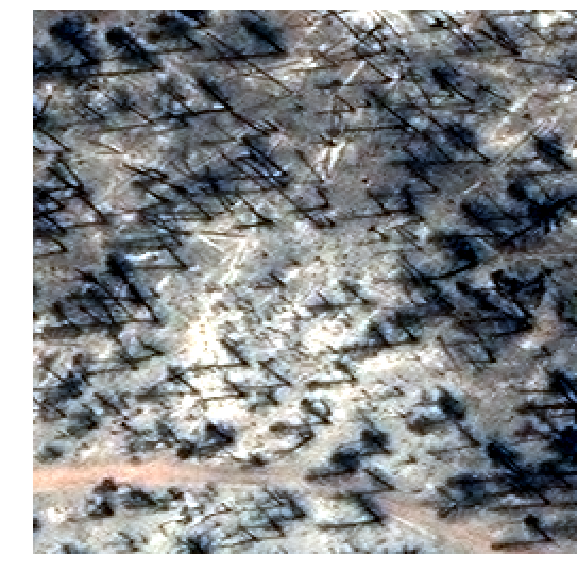

In [25]:
tiles[len(tiles)/2].plot()

### Segmentation

I will show you what the segments will look like for one of the tile. Play with the segmentation slic parametersto try to separate out the road, trees, and burned grass.

In [6]:
rgb = tiles[len(tiles)/2].rgb()

In [7]:
from skimage import transform, feature, segmentation, util, filters, exposure, morphology, data, io, measure, color, img_as_bool


In [8]:
img_segmented = segmentation.slic(rgb, n_segments=1000, compactness=10, sigma=1)

Number of segments: 953


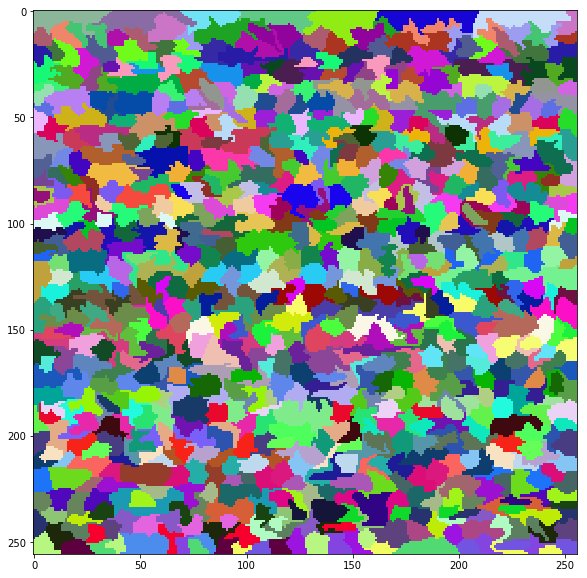

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0) #keep same colors
cmap = matplotlib.colors.ListedColormap(np.random.rand(256,3))
plt.figure(figsize=(10,10))
plt.imshow(img_segmented, cmap=cmap)
print "Number of segments:", np.max(img_segmented)

In [10]:
!pip install git+https://github.com/aalten77/nbburntbuildings.git@master -q
import nbburntbuildings

Below is the result for the segmented image. If this looks good to you, then keep the parameter for all tiles. 

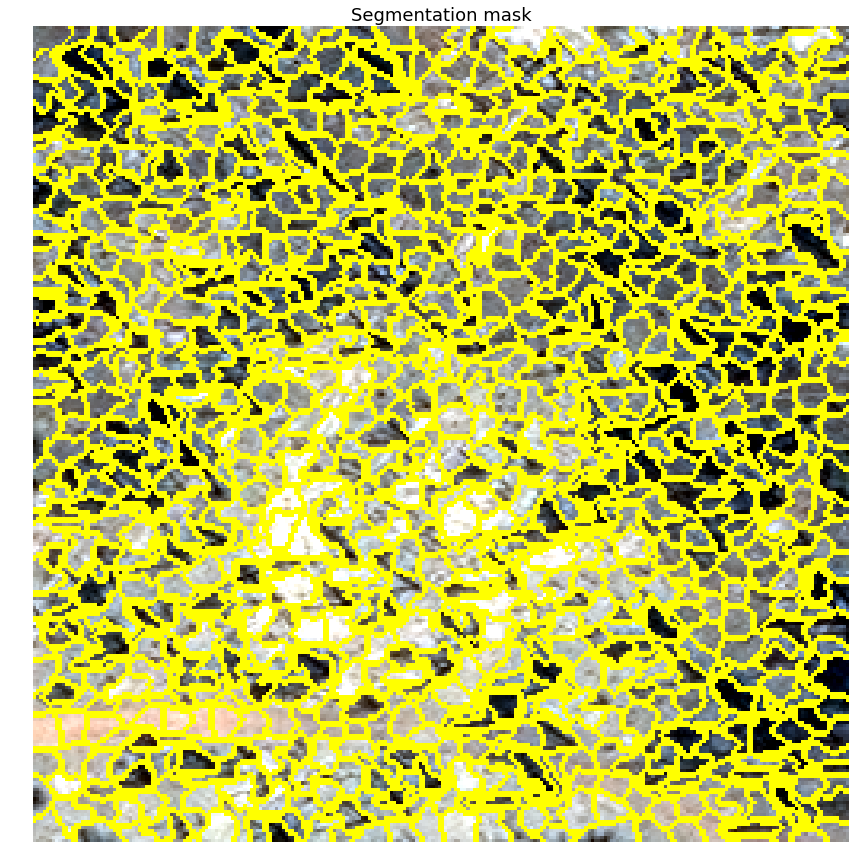

In [11]:
sp = plt.figure(figsize=(15,15))
nbburntbuildings.plot_array(segmentation.mark_boundaries(rgb, img_segmented), (1,1,1), title="Segmentation mask")
_ = plt.plot()

We will randomly select about 10-20% of the tiles. random.sample() will shuffle and return your random tiles as a list.

In [12]:
import random
tiles_random = random.sample(tiles, 61) # randomly select 61 tiles from tiles

Now you will segment each tile using SLIC. 

In [13]:
import tqdm
segmented_images = [segmentation.slic(tile.rgb(), n_segments=1000, compactness=10, sigma=1) for tile in tqdm.tqdm_notebook(tiles_random)]

### Converting segments to shapely polygons

This step is required to append the polygons to a geojson. Look through the next 4 steps to see how this is done. 

In [16]:
import shapely
from shapely.geometry import Polygon, mapping, shape, MultiPolygon, box
from rasterio import features

In [17]:
segment_mask = segmented_images[0].astype(np.uint16)

In [18]:
list_of_shapes = []

In [19]:
for i, seg_img in enumerate(tqdm.tqdm_notebook(segmented_images)):
    segment_mask = seg_img.astype(np.uint16)
    list_of_shapes.append([(shapely.geometry.shape(g), v) for g, v in features.shapes(segment_mask, mask=None, transform=tiles_random[i].affine)])

### Convert to geojson

First, I define to_geojson() here. This takes the shapely polygons and builds a geojson. If you need to change the CRS, you can do so in the collection dictionary. Change the catalog_id as necessary for your wildfire image. 

In [22]:
def to_geojson(shapes_list):

    #append burn scar region polygons to geojson
    #**Note: 'color' isn't necessary, but you can change it if you want to view the polygons in your preferred GIS software
    if type(shapes_list) == list:
        results = ({
            'type': 'Feature',
            'properties': {'raster_val': v, 'color': 'red'},
            'geometry': s.__geo_interface__}
            for i, (s, v)
            in enumerate(shapes_list))
    else:
        results = ({
            'type': 'Feature',
            'properties': {'raster_val': v, 'color': 'red'},
            'geometry': s}
            for i, (s, v)
            in enumerate(shapes_list))

    list_results = list(results)

    #properties will contain catalog_id that is read in 1_geojson_to_feats.py
    collection = {
        'type': 'FeatureCollection',
        'features': list_results, 
        'properties': {'catalog_id':'104001003473E900', 'fire_name':'Tubbs Fire', 'location':'Santa Rosa, CA'},
        'crs': {'type':'EPSG', 'properties':{'code':4326}}
    }

    return collection

The cell will create a bunch of geojsons for each tile. You will need to run my Combine_geojsons.py script to combine the geojsons. 

In [ ]:
import json
for i, shapes in enumerate(list_of_shapes):
    gj = to_geojson(shapes)
    with open('./wildfire_geojsons/SpringCreekFire/SpringCreekFire_{}.json'.format(i), 'w') as f:
        json.dump(gj, f)